In [13]:
!pip install ucimlrepo

In [14]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

In [15]:
# !! DO NOT MODIFY THIS CELL !!

# Download and preprocess the dataset.
# fetch dataset
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
# Convert categorical features into one-hot encode
categorical_features = ['cp','thal','slope','restecg']
X = pd.get_dummies(X, columns=categorical_features)

y = heart_disease.data.targets
print(f"Number of samples in all full dataset is: {len(X)}.")

# Check if our train set has missing value
na_in_features = X.isna().any(axis=1).sum()
na_in_trainY = y.isna().sum()
print(f"Number of rows with missing values in features: {na_in_features}")

# Drop the rows with missing values.
indices_with_nan = X.index[X.isna().any(axis=1)]
X = X.drop(indices_with_nan)
y = y.drop(indices_with_nan)

# Divide train/test
np.random.seed(6464)
msk = np.random.rand(len(X)) < 0.75
X_train = X[msk]
X_test = X[~msk]
y_train = y[msk]
y_test = y[~msk]

# Convert problem to binary problem
X_train = np.array(X_train,dtype='float')
X_test = np.array(X_test,dtype='float')
y_train = np.array([-1 if i==0 else 1 for i in y_train.values],dtype='float')
y_test = np.array([-1 if i==0 else 1 for i in y_test.values],dtype='float')

print(f"Shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

Number of samples in all full dataset is: 303.
Number of rows with missing values in features: 4
Shapes: X_train: (216, 22), y_train: (216,), X_test: (83, 22), y_test: (83,)


In [16]:
# Normalize X_train and X_test using the statistics of X_train.
# 1. Compute the mean and standard deviation for each feature in X_train
# 2. Subtract the mean from each feature and divide by the standard deviation
#    for both X_train and X_test.

# Calculate the mean and std of each feature in X_train
mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)

# Normalize X_train
X_train_normalized = (X_train - mean_X_train) / std_X_train
# Normalize X_test
X_test_normalized = (X_test - mean_X_train) / std_X_train

# You can preporcess with from-scratch code too. See below:
# mean_X_train = [sum(X_train[:,j])/X_train.shape[0] for j in range(X_train.shape[1])]
# std_X_train = [np.sqrt(sum((X_train[:,j]-mean_X_train[j])**2)/X_train.shape[0]) for j in range(X_train.shape[1])]
# X_train_normalized = X_train
# X_test_normalized = X_test
# for j in range(X_train.shape[1]):
#     X_train_normalized[:,j] = (X_train[:,j]-mean_X_train[j])/std_X_train[j]
#     X_test_normalized[:,j] = (X_test[:,j]-mean_X_train[j])/std_X_train[j]

In [17]:
# Print the mean and standard deviation of the first and last feature.

print(f"The first feature mean: {mean_X_train[0]}, standard deviation: {std_X_train[0]}")
print(f"The last feature mean: {mean_X_train[-1]}, standard deviation: {std_X_train[-1]}")

The first feature mean: 54.99074074074074, standard deviation: 9.077847854724455
The last feature mean: 0.5046296296296297, standard deviation: 0.49997856607007907


In [18]:
# Train SVM

# Complete the `trainSVM` function to find the optimal w and b that minimize
# the primal SVM objective given in the write-up.
# The function takes three inputs:
# - trainX: the normalized train features with shape (#train_samples, #features)
# - trainY: train labels with shape (#train_samples,)
# - C: C parameter of the minimization problem
# The function should return a three-tuple with:
# - w: the weight vector with shape (#features,)
# - b: the bias. A scalar with shape (1,)
# - xi: the slack variables with shape (#train_samples,)

# You can use cvxpy that we imported as cp
# You may find cp.Variable, cp.Minimize, cp.Problem useful
# For the problem solver, prefer the default, cp.CLARABEL

def trainSVM(trainX, trainY, C):
    N, d = trainX.shape

    w = cp.Variable(d)
    b = cp.Variable()
    xi = cp.Variable(N)

    objective = cp.Minimize(0.5 * (cp.norm2(w) ** 2) + C * cp.sum(xi))
    constraints = [
        cp.multiply(trainY, (trainX @ w + b)) >= 1 - xi,
        xi >= 0
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value, b.value, xi.value

In [19]:
# Solve SVM with C = 1 and print the first three weights, b and the first
# three slack variables as instructed in the write-up

w,b,xi =trainSVM(X_train_normalized, y_train,1)
print(f"With C = 1, first three weights: {w[:3]}, b: {b}, first three slack variables: {xi[:3]}")

With C = 1, first three weights: [-0.01280084  0.51706872  0.27813637], b: 0.08109278708402816, first three slack variables: [-1.70119115e-10 -1.64395685e-10 -1.69587197e-10]


In [20]:
# Solve SVM with C = 0 and print the first three weights, b and the first
# three slack variables as instructed in the write-up

w,b,xi =trainSVM(X_train_normalized, y_train,0)
print(f"With C = 0, first three weights: {w[:3]}, b: {b}, first three slack variables: {xi[:3]}")

With C = 0, first three weights: [ 3.09523259e-06 -8.18802636e-06 -9.46615246e-06], b: -10.447621082517607, first three slack variables: [429.58840105 434.02071004 414.34670026]


In [21]:
# Eval SVM

# Write a function to evaluate the SVM model given its `w` and `b` parameters
# on evaluation data `X_eval` and true labels `y_eval`.
#  1. Estimate the labels of `X_eval`.
#  2. Return the ratio of accurately estimated labels by comparing with `y_eval`.

def evalSVM(X_eval, y_eval, w, b):
    y_pred = np.sign(X_eval @ w + b)
    accuracy = np.mean(y_pred == y_eval)
    return accuracy

In [22]:
train_accuracies = []
test_accuracies = []
C_values = []

# For each C value given in the homework, find optimal w, b
# values using the normalized train set. Calculate the accuracy
# on train and test sets using found w and b.
# Save those values as we will plot them

for i in [-4,-3,-2,-1,0,1]:
    for j in [1,3,6]:
        C_values.append(j*10**i)
for C in C_values:
    w, b, _ = trainSVM(X_train_normalized, y_train, C)
    train_accuracies.append(evalSVM(X_train_normalized, y_train,w,b))
    test_accuracies.append(evalSVM(X_test_normalized, y_test,w,b))

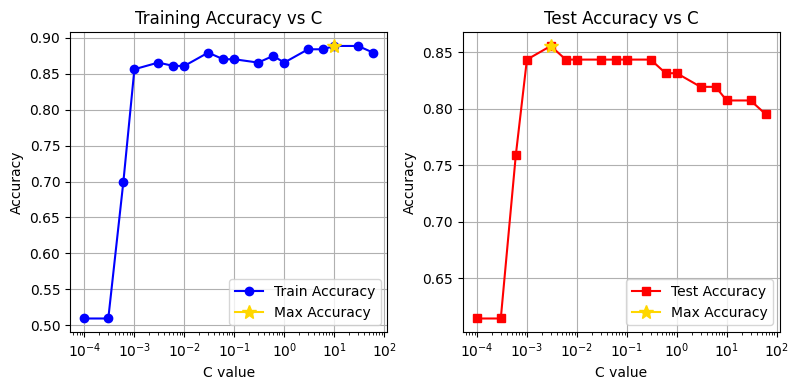

The maximum training accuracy is 0.8889 when C is 10.000 for training accuracy.
The maximum test accuracy is 0.8554 when C is 0.003 for test accuracy.


In [23]:
# Plotting and reporting the desired values

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

max_train_idx = np.argmax(train_accuracies)
max_test_idx = np.argmax(test_accuracies)

# Plot training accuracies
ax[0].plot(C_values, train_accuracies, marker='o', linestyle='-', color='b', label='Train Accuracy')
ax[0].plot(C_values[max_train_idx], train_accuracies[max_train_idx], marker='*', color='gold', markersize=10, label='Max Accuracy')
ax[0].set_title('Training Accuracy vs C')
ax[0].set_xlabel('C value')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)
ax[0].set_xscale('log')

# Plot test accuracies
ax[1].plot(C_values, test_accuracies, marker='s', linestyle='-', color='r', label='Test Accuracy')
ax[1].plot(C_values[max_test_idx], test_accuracies[max_test_idx], marker='*', color='gold', markersize=10, label='Max Accuracy')
ax[1].set_title('Test Accuracy vs C')
ax[1].set_xlabel('C value')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True)
ax[1].set_xscale('log')

plt.tight_layout()
plt.show()

print(f"The maximum training accuracy is {train_accuracies[max_train_idx]:.4f} when C is {C_values[max_train_idx]:.3f} for training accuracy.")
print(f"The maximum test accuracy is {test_accuracies[max_test_idx]:.4f} when C is {C_values[max_test_idx]:.3f} for test accuracy.")
